In [135]:
import random as rd
import numpy as np
import scipy as sp
from math import inf

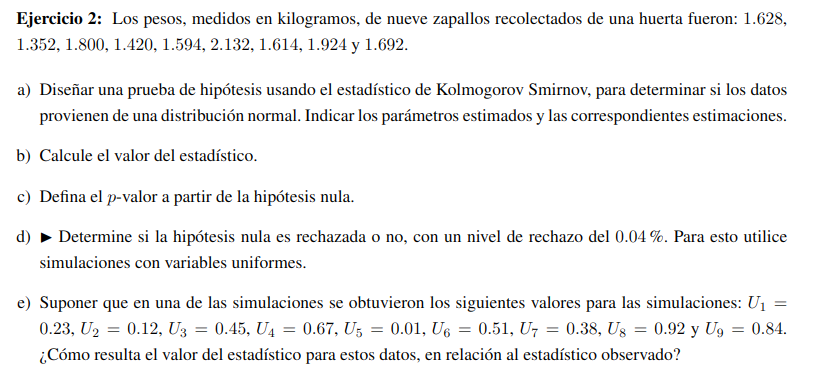

In [136]:
muestra = [1.628, 1.352, 1.800, 1.420, 1.594, 2.132, 1.614, 1.924, 1.692]
print(round(np.mean(muestra),4))
print(round(np.std(muestra),4))

1.684
0.228


In [137]:
def F_hat(x):
    return sp.stats.norm.cdf(x, loc=1.684, scale=0.228)

def estadistico_K_S(fun, muestra):
    n = len(muestra)
    muestra = np.sort(muestra)
    D = 0
    for i in range(n):
        izq = ((i+1)/n) - fun(muestra[i])
        der = fun(muestra[i]) - (i/n)
        D = max(D, izq, der)
    return D

In [138]:
estadistico_K_S(F_hat, muestra)

0.15267156364859913

In [139]:
def estimar_pvalor_K_S(nsims, fun, x_n):
    n = len(x_n)
    D = estadistico_K_S(fun, x_n)
    hits = 0
    for i in range(nsims):
        """ 
        Debo generar nsims muestras de tamaño n de una distribución uniforme, 
        y calcular el estadistico D. Luego el p-valor es la proporcion de
        veces que D es mayor que el estadistico de la muestra original. 
        """
        muestra_sim = np.random.uniform(size=n)
        D_sim = estadistico_K_S(lambda x: x, muestra_sim)
        if D_sim > D:
            hits += 1
    return hits/nsims

In [140]:
estimar_pvalor_K_S(10000, F_hat, muestra)

0.963

In [141]:
datos = [0.23, 0.12, 0.45, 0.67, 0.01, 0.51, 0.38,0.92 ,0.84]
estadistico_K_S(lambda x: x, datos)

0.15666666666666662

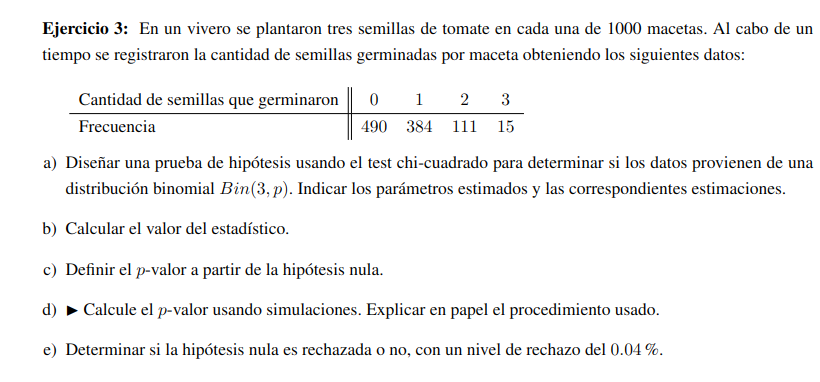

In [142]:
Ni = [490, 384, 111, 15]
n = sum(Ni)
print(f"Tamaño de la muestra: {n}")
x_bar = (0*490 + 1*384 + 2*111 + 3*15) / n
p_hat = x_bar / 3 
print(p_hat)
p_0 = sp.stats.binom.pmf(0, 3, p_hat)
p_1 = sp.stats.binom.pmf(1, 3, p_hat)
p_2 = sp.stats.binom.pmf(2, 3, p_hat)
p_3 = sp.stats.binom.pmf(3, 3, p_hat)
pi = [round(p_0,4), round(p_1,4), round(p_2,4), round(p_3,4)]
print(pi)

Tamaño de la muestra: 1000
0.217
[0.48, 0.3991, 0.1106, 0.0102]


In [143]:
def estadistico(n, pi,Ni):
    t = 0
    for i in range(len(Ni)):
        t += ((Ni[i] - n*pi[i])**2)/(n*pi[i])
    return round(t,4)

def calcular_pvalor_param(t, k, m):
    return 1 - sp.stats.chi2.cdf(t, k-1-m)

In [144]:
estadistico(n, pi, Ni)

3.0399

In [145]:
calcular_pvalor_param(estadistico(n, pi, Ni), 4, 1)

0.2187228228199568

In [146]:
"""  
Simula el pvalor en nsims siulaciones.

Parametros:
nsims: int, cantidad de simulaciones a realizar
n: int, tamaño de la muestra
pi: list, probabilidades de la distribución
Ni: list, frecuencias observadas
"""
def simular_pvalor(nsims, n, pi, Ni):
    x_bar = (0*Ni[0] + 1*Ni[1] + 2*Ni[2] + 3*Ni[3]) / n
    p_hat = x_bar / 3
    t0 = estadistico(n, pi, Ni)
    hits = 0
    Ni_sim = [0, 0, 0, 0]
    pi_sim = [0, 0, 0, 0]
    for i in range(nsims):
        muestra_sim = np.random.binomial(3, p_hat, size=n)
        p_hat_sim = np.mean(muestra_sim)/3
        # recalculo las probabilidades para cada grupo con la nueva p_hat
        pi_sim[0] = round(sp.stats.binom.pmf(0, 3, p_hat_sim),4)
        pi_sim[1] = round(sp.stats.binom.pmf(1, 3, p_hat_sim),4)
        pi_sim[2] = round(sp.stats.binom.pmf(2, 3, p_hat_sim),4)
        pi_sim[3] = round(sp.stats.binom.pmf(3, 3, p_hat_sim),4)
        for j in range(len(Ni_sim)):
            Ni_sim[j] = np.sum(muestra_sim == j)
        t_sim = estadistico(n, pi_sim, Ni_sim)
        if t_sim > t0:
            hits += 1
    return hits/nsims

In [147]:
nsims = 10000
simular_pvalor(nsims, n, pi, Ni)

0.218

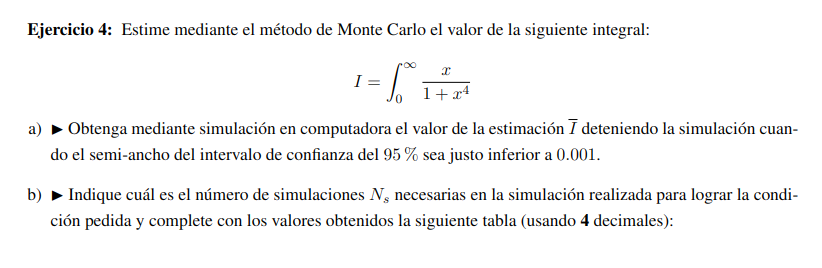

Como el ancho del intervalo esta dado por 
$$
l = 2\cdot z_{\alpha/2} \cdot \frac{S(n)}{\sqrt{n}}
$$

Y lo que quiero es controlar que la mitad del ancho sea justo inferior a 0.001, entonces lo que debo controlar en la condicion de mi algoritmo es:
$$
z_{\alpha/2} \cdot \frac{S(n)}{\sqrt{n}} < 0.001 \\
\frac{S(n)}{\sqrt{n}} < \frac{0.001}{z_{\alpha/2}}
$$

De esta manera puedo controlar el semi-ancho del intervalo

In [148]:
def fun(x):
    return (x/(1+x**4))

In [151]:
def montecarlo_0_inf(fun, z_alfa_2, L, max_it):
    d = L / z_alfa_2
    n = 1
    y = rd.random()
    mean = fun((1/y) - 1) / (y**2)
    Scuad = 0
    while n<max_it and (n<=100 or np.sqrt(Scuad/n)> d): # desviacion estandar de la media muestral
        n+=1

        y = rd.random()
        x = fun((1/y) - 1) / (y**2)

        old_mean = mean
        mean = old_mean + ((x - old_mean) / n)
        
        Scuad = (1 - 1/(n-1))*Scuad + n*((mean - old_mean)**2)

    ancho = 2*z_alfa_2*np.sqrt(Scuad/n)
    S = Scuad**0.5
    izq_IC = mean - z_alfa_2*S/(n**0.5)
    der_IC = mean + z_alfa_2*S/(n**0.5)
    IC = [round(izq_IC,4), round(der_IC,4)]
    return n, round(mean,4), round(S,4), IC # valores genrados, media muestral, varianza muestral

In [152]:
print("Nsims | Estimacion | Desviacion | IC")
print(montecarlo_0_inf(fun, 1.96, 0.001, 1000))
print(montecarlo_0_inf(fun, 1.96, 0.001, 5000))
print(montecarlo_0_inf(fun, 1.96, 0.001, 7000))
print(montecarlo_0_inf(fun, 1.96, 0.001, inf))

Nsims | Estimacion | Desviacion | IC
(1000, 0.8068, 0.6702, [0.7653, 0.8484])
(5000, 0.7551, 0.6516, [0.7371, 0.7732])
(7000, 0.7736, 0.6573, [0.7582, 0.789])
(1682546, 0.7846, 0.6618, [0.7836, 0.7856])
